In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
from keras.backend import int_shape

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import cutOut

def provideData(flatten=False,dimension=None,batch_size=None,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    return train,test
    
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (128,128)
channels = 5
batch_size=50
optimizer = Adam( lr = 1e-3 )
slices = [224,352,224,352]
slices_label = [32,64+32,32,64+32]
cutOutFrame = cutOut(slices)
cutOutFrame_label = cutOut(slices_label)

PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label]


tfd = tfp.distributions

train, test = provideData(flatten=False,dimension=dimension,batch_size=batch_size,transform=TRANSFORMATION,preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [3]:
def lstmLayer(inp,filters = [20,20]):

    shape_inp = int_shape(inp)


    lstm_shape = Reshape((shape_inp[-1],shape_inp[1],shape_inp[2],1))(inp)


    lstm_conv = ConvLSTM2D(filters=filters[0], kernel_size=(3, 3), activation='relu',
                       padding='same', return_sequences=True,data_format='channels_last')(lstm_shape)
    
    

    for i in filters[1:-1]:
        lstm_conv = ConvLSTM2D(filters=i, kernel_size=(3, 3), activation='relu',
                       padding='same', return_sequences=True,data_format='channels_last')(lstm_conv)
        

    lstm_conv = ConvLSTM2D(filters=filters[-1], kernel_size=(3, 3), activation='relu',
                       padding='same', return_sequences=False,data_format='channels_last')(lstm_conv)
    

    return lstm_conv


def LSTM_Unet_Poisson(input_shape,
                    n_predictions=1,
                    simpleclassification=None,
                    flatten_output=False,
                    activation_hidden="relu",
                    activation_output="relu"):

    
    inputs = Input(shape=input_shape)


    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            
    

    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            
    
    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            
    

    lstm_conv3 = lstmLayer(conv03,filters = [20,20,20])
    conv03 = concatenate([conv03, lstm_conv3], axis=3)

    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            
    

    lstm_conv4 = lstmLayer(conv04,filters = [20,20,20,20])
    conv04 = concatenate([conv04, lstm_conv4], axis=3)

    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    
    up04 = concatenate([conv04, up04], axis=3)  
    up04 = Conv2D(20, kernel_size=(3, 3), padding="same")(up04)  
    

    up03 = UpSampling2D((2, 2))(up04)           
    up03 = concatenate([conv03, up03], axis=3)  
    up03 = Conv2D(20, kernel_size=(3, 3), padding="same")(up03)  
    
    
    up02 = UpSampling2D((2, 2))(up03)           
    up02 = concatenate([conv02, up02], axis=3)  
    up02 = Conv2D(20, kernel_size=(3, 3), padding="same")(up02)  
    
    """
    up01 = UpSampling2D((2, 2))(up02)           
    up01 = concatenate([conv01, up01], axis=3)  
    up01 = Conv2D(20, kernel_size=(3, 3), padding="same")(up01)  
    """
    layer = Conv2D(1, (64, 64), activation='tanh',padding="same")(up02) 
    #output = layer   
    output = Flatten()(layer)
    
    #output = Dense(2048)(output)
    output = Dense(64*64)(output)
    #output = tf.reshape(output, tf.shape(output))
    output = tfp.layers.IndependentPoisson((64,64,1))(output)
    
    model = Model(inputs=inputs, outputs=output)

    return model

In [4]:
model = LSTM_Unet_Poisson((*dimension,5))
model.compile(loss=lambda y, model_normal: -model_normal.log_prob(y), optimizer=Adam( lr= 1e-3 ),metrics = ["mse","mae"])
#model.compile(loss="mse", optimizer=Adam( lr= 1e-4 ))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 10) 460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 10) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 10)   0           activation[0][0]                 
______________________________________________________________________________________________

In [5]:
history = model.fit(train,validation_data=test,epochs=30)

Epoch 1/30


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


637/637 [==============================] - 385s 604ms/step - loss: 189.7133 - mse: 0.0161 - mae: 0.0177 - val_loss: 180.9465 - val_mse: 0.0072 - val_mae: 0.0142
Epoch 2/30
637/637 [==============================] - 384s 603ms/step - loss: 165.7071 - mse: 0.0079 - mae: 0.0135 - val_loss: 189.2493 - val_mse: 0.0050 - val_mae: 0.0120
Epoch 3/30
637/637 [==============================] - 386s 607ms/step - loss: 168.2739 - mse: 0.0080 - mae: 0.0136 - val_loss: 204.0809 - val_mse: 0.0032 - val_mae: 0.0101
Epoch 4/30
637/637 [==============================] - 374s 588ms/step - loss: 171.4100 - mse: 0.0081 - mae: 0.0138 - val_loss: 196.5051 - val_mse: 0.0068 - val_mae: 0.0137
Epoch 5/30
637/637 [==============================] - 374s 587ms/step - loss: 168.9657 - mse: 0.0080 - mae: 0.0136 - val_loss: 182.4907 - val_mse: 0.0075 - val_mae: 0.0144
Epoch 6/30
637/637 [==============================] - 373s 586ms/step - loss: 167.9940 - mse: 0.0080 - mae: 0.0136 - val_loss: 187.5375 - val_mse: 0.01

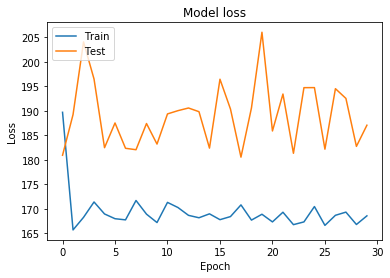

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
h = history.history

def plotHistory():

    # Plot training & validation loss values
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline

In [11]:

pred = None
label = None
test.on_epoch_end()
mean = []
stdev = []
label = []
for x,y in train:
    for i in range(batch_size):
        
        pred = model(np.array([x[i,:,:,:]]))
        mean.append(pred.mean() )
        #stdev.append(pred.stddev())
        label.append(y[i,:,:,:])
        #mean = model(x).mean()
        #std = model(x).stddev()
        #label = y
    break

(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)


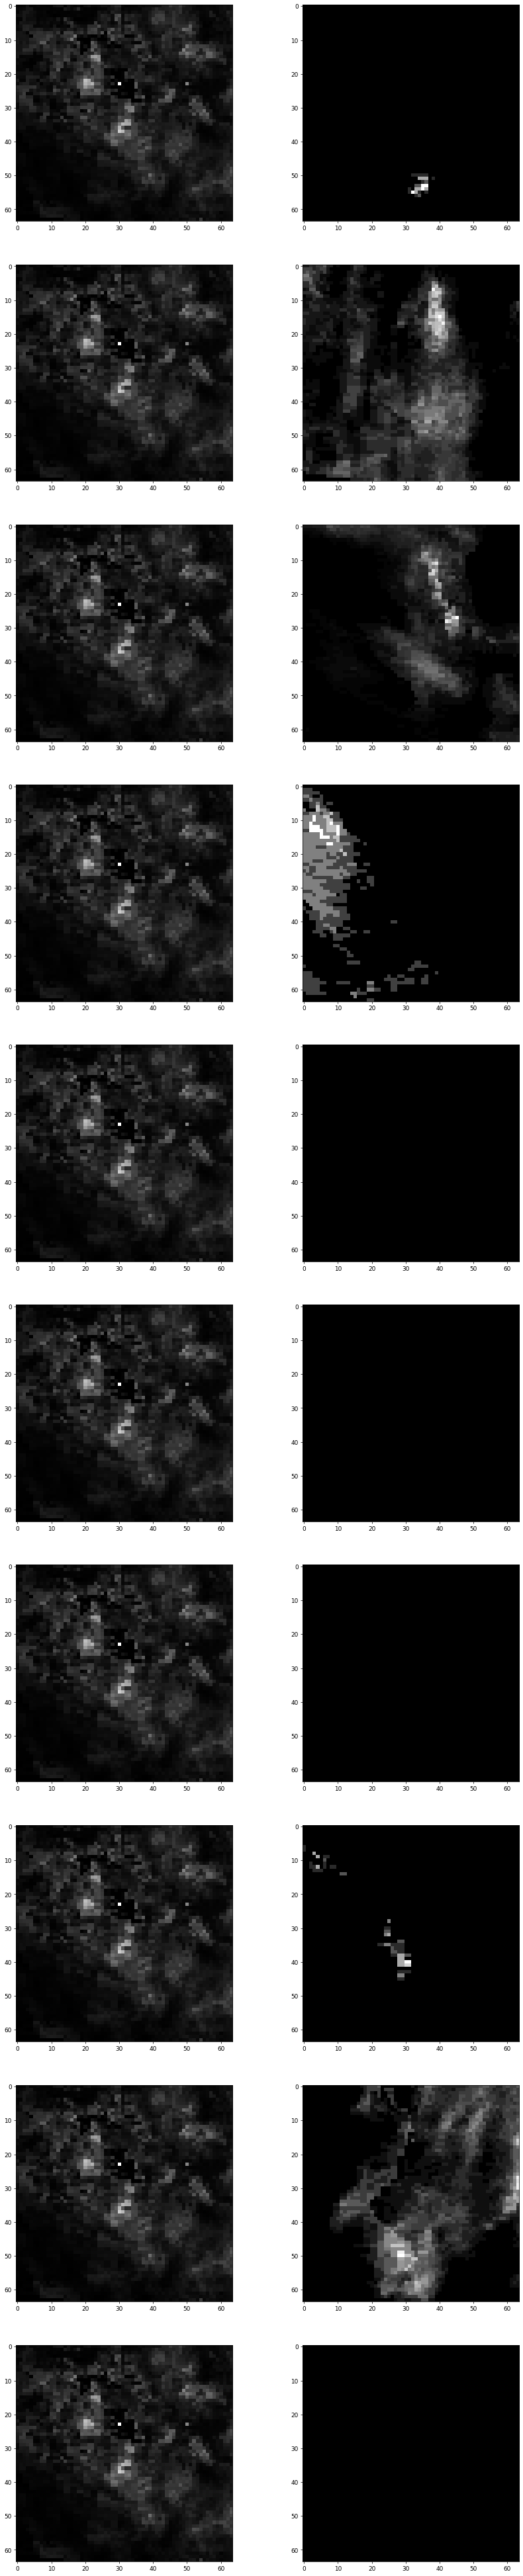

In [16]:
fig, axes = plt.subplots(10, 2, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,0].imshow(img[0,:,:,0],cmap="gray")
    #axes[batch,1].imshow(stdev[batch][:,:,0],cmap="gray")
    axes[batch,1].imshow(label[batch][:,:,0],cmap="gray")

In [ ]:
print(np.array(mean).min())